# Практическое задание

## Интерполяция байеровского шаблона (demosaicing)

### О задании

В этом задании вам предстоит познакомится с простейшими инструментами считывания и обработки изображений в python, и с помощью них реализовать и протестировать 2 метода интерполяции байеровского шаблона. 

### Инструменты

Задание предполагает использование `python3`, не ниже версии `3.5`. 
Вам понадобится работать со следущими пакетами:

* [`numpy`](https://docs.scipy.org/doc/numpy/reference/index.html) - библиотека для работы с многомерными масивами и матрицами, содержащая большое кол-во высокоуровневых математических функций для операций с этими масивами.  


* [`skimage`](http://scikit-image.org/) - библиотека, содержащие большую коллекцию алгоритмов для обработки изображений;

* [`scipy`](https://www.scipy.org/) - библиотека, содержащая большой набор инструментов для математических и инженерных вычислений. Основная структура данных numpy массив.

* [`matplotlib`](https://matplotlib.org/) - библиотека для визуализации различных графиков, диаграмм, изображений и много другого.

In [1]:
#!pip install numpy scikit-image scipy matplotlib

### Общая информация

Фильтр Байера - это матрица цветных фильтров для фотосенсора фотоаппарта. Каждая ячейка матрицы представляет собой фильтр одного из цветов R, G или B. В классическом фильтре Байера применяются светофильтры трёх основных цветов в следующем порядке: <img src="bayer_pat.png" width="50">
Матрица является устройством, воспринимающим спроецированное на него изображение. Вследствие использования фильтров каждый фотоприемник воспринимает лишь 1/3 цветовой информации участка изображения, а 2/3 отсекается фильтром. Недостающие компоненты цвета рассчитываются процессором камеры на основании данных из соседних ячеек в результате интерполяции (demosaicing).
<img src="bayer.jpg" width="500">

Вам необходимо будет научиться востанавливать "полноцветное" изображение по байеровскому шаблону.

Вместе с заданием вам был выдан архив `data.zip`. В нем содержатся следущие данные:
* `raw/` - директория с  различными одноканальными изображениями, полученными с помощью фильтра Байера. Фильтр Байера который применялся, соответствует последовательности каналов(GRGB), показанной выше. В каждом пикселе изображения записан отклик фильтра соответсвующего цвета;
* `gt/` - директория с *ground truth* изображениями, каждому raw-изображению из предыдущей директории существует изображение из этой директории(с тем же именем) с истинными значениями RGB-канналов в каждом пикселе;
* `debug/` - изображения для самопроверки работы алгоритмов.

Выполненный нотбук сдается вместе с папкой `results`, где должны лежать результаты работы алгоритмов. Ниже будет описано подробнее. Все необходимо заархивировать в один zip файл.

### Практическая часть

In [2]:
import skimage.io
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
GT_DIR = 'data/gt/'
RAW_DIR = 'data/raw/'

**1. (0.5 балла)**

Считайте raw и ground truth изображения `IMG0001.bmp`, выведите в какой тип данных они считались(список, массив, ...?), какой тип данных у пикселей изображения(float, int, ...?), размеры изображений.  Подумайте на тем как хранятся изображения в памяти.

Вам могут понадобиться:
* `skimage.io.imread(..)`

**Hint**: в jupyter-notebook если после ввода названия функции нажать сочетание клавиш `shift+tab` , выведется докстринг этой функции.

Теперь давайте посмотрим на считанные изображения. Для этого воспользуемся:
* `matplotlib.pyplot.subplots(...)` для создания фигуры, заданного размера, с нужным нам количеством окон
* `matplotlib.axes.Axes.imshow(...)` методом объекта `matplotlib.axes.Axes` для вывода изображения

In [4]:
gt_image = skimage.io.imread(os.path.join(GT_DIR, 'IMG0001.bmp'))
raw_image = skimage.io.imread(os.path.join(RAW_DIR, 'IMG0001.bmp'))

print("Тип считанного изображения:", type(gt_image), type(raw_image))
print('Типы элементов матриц:', gt_image.dtype, raw_image.dtype)
print("Размеры:", gt_image.shape, raw_image.shape)

Тип считанного изображения: <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Типы элементов матриц: uint8 uint8
Размеры: (512, 768, 3) (512, 768)


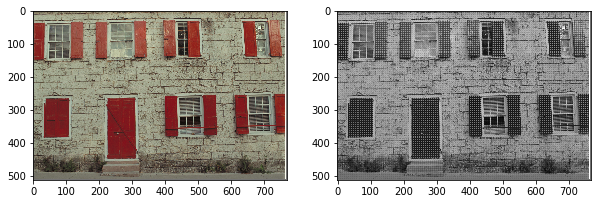

In [5]:
figure, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(gt_image)
axs[1].imshow(raw_image, cmap='gray')
plt.show()

**2. (0.5 балла)**

Перейдем непосредственного к интерепполяции байеровского шаблона.
Напишите вспомогательную функцию, которая для заданного размера raw-изображения создает маски для красных, зеленых и синих каналов байровского шаблона.

Вам могут понадобиться:
* `numpy.tile(...)`

In [6]:
def get_bayer_pattern_masks(h, w):
    """
    Get 3 masks for red, green, blue channels of bayer pattern size (h, w)

    :param h: int, height of bayer pattern
    :param w: int, width of bayer pattern
    :return: [numpy.ndarray((h, w)), numpy.ndarray((h, w)), numpy.ndarray((h, w))],
    list of 3 mask, size (h, w) for red, green, blue channels respectively
    """
    num_h = h // 2 + 1
    num_w = w // 2 + 1

    r_block = np.array([
        [0, 1],
        [0, 0]]
    )
    g_block = np.array([
        [1, 0],
        [0, 1]]
    )
    b_block = np.array([
        [0, 0],
        [1, 0]]
    )

    r = np.tile(r_block, (num_h, num_w))[:h, :w]
    g = np.tile(g_block, (num_h, num_w))[:h, :w]
    b = np.tile(b_block, (num_h, num_w))[:h, :w]
    
    return r, g, b

Проверьте правильность работы  функции с помощью простейшего теста.

In [7]:
# small test for self-examination
r, g, b = get_bayer_pattern_masks(3, 3) 
assert (r == np.array([
    [0, 1, 0], 
    [0, 0, 0], 
    [0, 1, 0]]
)).all()
assert (g == np.array([
    [1, 0, 1], 
    [0, 1, 0], 
    [1, 0, 1]]
)).all()
assert (b == np.array([
    [0, 0, 0], 
    [1, 0, 1], 
    [0, 0, 0]]
)).all()

**3. (0.5 балла)**

Посмотрим, что на самом деле хранится в raw-изображениях. Напишите функцию, которая создает цветное изображение из raw-изображения следущим образом: в каждый цветовой канал поместите только известные пиксели из raw-изображения, пиксели, в которых данный цвет неизвестен, поставьте 0. Сохраните данное изображение в файл `results/colored_raw_image.bmp` и посмотрите что получилось.

Вам может пригодиться:
* `np.where(...)`
* `skimage.io.imsave(...)`

In [8]:
def get_colored_raw_image(raw_image):
    """
    Create colored raw image.
    
    :param raw_image: numpy.ndarray((h, w), dtype=np.uint8), raw image created with bayer pattern
    :return: numpy.ndarray((h, w, 3), dtype=np.uint8), colored raw image
    """
    (h, w) = raw_image.shape
    r, g, b = get_bayer_pattern_masks(h, w)
    
    r = (r * raw_image).astype(np.uint8)
    g = (g * raw_image).astype(np.uint8)
    b = (b * raw_image).astype(np.uint8)
    
    colored_raw_image = np.dstack((r, g, b))
    
    return colored_raw_image

In [9]:
colored_raw_image = get_colored_raw_image(raw_image)
os.makedirs('results/', exist_ok=True)

skimage.io.imsave('results/colored_raw_image.bmp', colored_raw_image)

**4. (3 балла)**

Напишите алгоритм билинейной интерполяции байеровского шаблона. В этом алгоритме **неизвестные** значения цветовых компонент вычисляются следущим образом:
* рассматривается окно 3x3 с центром в данном пикселе
* значение цветовой компоненты(r, g, или b) в данном пикселе вычисляется как среднее **заданных** значений данной цветовой компоненты пикселей в этом окне

Например, если, мы хотим интерполировать значение зеленой компоненты цвета в пикселе отмеченном '$+$' на рисунке, нам необходимо усреднить значение 4-х зеленых конпонент в 3x3 окрестности, отмеченных '$\cdot$' 

<img src="example.png" width="130">

В данном задание разрешается обходить матрицу и попиксельно вычислять цветовые компоненты. На будущих занятих вы познакомитесь с понятием "cвертка", и узнаете как на питоне можно было бы избежать обхода матрицы.

Вам может пригодиться:
* `numpy.stack(...)`
* `numpy.rint(...)`

**Замечания:** 
* Поведение на границе, где окно 3x3 неполное, выберите на свое усмотрение, при подсчете метрик оно учитываться не будет.
* Выполнение алгоритма на одном изображении не должно занимать более 20 секунд.
* Будьте аккуратны с вычислениями, raw-изображние хранит `uint8` значения. Для избежания ошибок, связанных с переполнением типа и округлением, рекомендуется в самом начале вычислений преобразовывать изображения в тип `float64`, а после окончания округлять значения до целых с помощью `numpy.rint(...)` и преобразовывать тип обратно в `uint8`.

In [10]:
def bilinear_interpolation(raw_image):
    """
    Perform bilinear interpolation demosaicing algorithm on raw image
    
    :param raw_image: numpy.ndarray((h, w), dtype=np.uint8), raw image created with bayer pattern
    :return: numpy.ndarray((h, w, 3), dtype=np.uint8), interpolated image
    """
    (h, w) = raw_image.shape
    
    image = np.zeros((h+2, w+2, 3), dtype=np.float64)
    image[1:-1, 1:-1, :] = get_colored_raw_image(raw_image)
    
    channels = np.zeros_like(image)
    channels[1:-1, 1:-1, :] = get_colored_raw_image(np.ones_like(raw_image))
    
    for i in range(1, h+1):
        for j in range(1, w+1):
            for k in range(3):
                if channels[i, j, k] == 0:
                    image[i, j, k] = (image[i-1: i+2, j-1: j+2, k]
                                      * channels[i-1: i+2, j-1: j+2, k]).sum() / channels[i-1: i+2, j-1: j+2, k].sum()
    
    image = image[1: -1, 1: -1, :]

    return np.rint(image).astype(np.uint8)

Проверьте правильность работы функции с помощью простейшего теста. 

In [11]:
# small test for self-examination
raw_image = skimage.io.imread('data/raw/IMG0001.bmp')
image_true = skimage.io.imread('data/debug/IMG0001_bilinear.bmp')
diff = np.abs(bilinear_interpolation(raw_image) - image_true)[1:-1, 1:-1].sum()
assert diff == 0

Вычислите билинейную интерполяцию байеровского шаблона для всех изображений из директории `raw/` и сохраните в директорию `results/bilinear/`. Посмотрите на результаты интерполяции, сделайте выводы о плюсах и минусах этого алгоритма.

In [14]:
OUTPUT_DIR = 'results/bilinear'
os.makedirs(OUTPUT_DIR, exist_ok=True)

file_names = os.listdir(RAW_DIR)
for file_name in file_names:
    full_name = os.path.join(RAW_DIR, file_name)
    raw_image = skimage.io.imread(full_name)
    bilinear = bilinear_interpolation(raw_image)
    skimage.io.imsave(os.path.join(OUTPUT_DIR, file_name), bilinear)

**Выводы:** Алгоритм прост в реализации, но на контурах изображённых объектов работает неточно.

**5. (1 балл)**

Для численной оценки работы алгоритма билинейной интерполяции реализуйте следущие метрики качества:

* Mean squared error $mse(pred\_image, gt\_image) = \frac{1}{3 * h * w} \sum_{i=1}^{h} \sum_{j=1}^{w} \sum_{c=1}^{3} (gt\_image[i, j, c] - pred\_image[i,j,c])^2$ 

* Peak signal-to-noise ratio $psnr(pred\_image, gt\_image) = 10 \log_{10}{(\frac{max(gt\_image)^2}{mse(pred\_image, gt\_image)} )}$

где $gt\_image$ - истинное изображение, $pred\_image$ - предсказанное.

Вычислите среднее значение этих метрик для всего датасета. При подсчете метрик не учитывайте, границу изображения, длиной в 2 пикселя.

Вам может понадобиться:
* `numpy.ndarray.mean(...)`
* `numpy.ndarray.max(...)`
* `numpy.log10(...)`

**Замечание:** Будьте аккуратны с вычислениями, raw-изображние хранит `uint8` значения. Для избежания ошибок, связанных с переполнением типа, рекомендуется в самом начале вычислений преобразовать изображение в тип `float64`.

In [16]:
def mse_score(pred_image, gt_image):
    """
    Compute mean squared error
    :param pred_image: numpy.ndarray((h, w, 3), dtype=np.uint8), predicted image
    :param gt_image: numpy.ndarray((h, w, 3), dtype=np.uint8), ground truth image
    :return:
    """

    pred_image = pred_image.astype(np.float64)
    gt_image = gt_image.astype(np.float64)
    
    mse = ((gt_image - pred_image) ** 2).mean()

    return mse


def psnr_score(pred_image, gt_image):
    """
    Compute peak signal-to-noise ratio
    :param pred_image: numpy.ndarray((h, w, 3), dtype=np.uint8), predicted image
    :param gt_image: numpy.ndarray((h, w, 3), dtype=np.uint8), ground truth image
    :return:
    """
    pred_image = pred_image.astype(np.float64)
    gt_image = gt_image.astype(np.float64)
    
    psnr = 10 * np.log10((gt_image.max() ** 2) / mse_score(pred_image, gt_image))

    return psnr

In [17]:
mean_mse = 0
mean_psnr = 0

file_names = os.listdir(GT_DIR)
for file_name in file_names:
    gt_image = skimage.io.imread(os.path.join(GT_DIR, file_name))
    pred_image = skimage.io.imread(os.path.join(OUTPUT_DIR, file_name))
    mean_mse += mse_score(pred_image, gt_image)
    mean_psnr += psnr_score(pred_image, gt_image)
    
mean_mse /= len(file_names)
mean_psnr /= len(file_names)

print("Mean mse score = ", mean_mse)
print("Mean psnr score = ", mean_psnr)

Mean mse score =  71.4507358692
Mean psnr score =  30.5975211756


**6. (3.5 балла)**

Теперь реализуем более сложную версию линейной интерполяции баеровского шаблона. Прочитайте статью, выданную вам совместно с ноутбуком, и реализуйте предложенный в ней алгоритм. Вычислите интерполяцию для всех изображений и сохраните в директорию `results/improved/`. Посчитайте средние значения метрик качества. 

**Замечания по поводу алгоритма:**
* в работе указанные фильтры неотнормированны к единице(сумма коэффициентов не равняется 1), чтобы сохранить масштаб значений, коэффициенты необходимо отнормировать на сумму значений в данном фильтре;
* в результате указанных в работе фильтров могут получаться значения большие 255 и меньшие 0, вам необходимо отрезать слишком большие и слишком маленькие значения по крайним значениям(`numpy.clip`);
* веса фильтров были выписаны в массивы за вас для избежания лишних ошибок.

**Замечание:** Как никогда будьте аккуратны с вычислениями, raw-изображние хранит `uint8` значения. Для избежания ошибок, связанных с переполнением типа и округлением, рекомендуется в самом начале вычислений преобразовывать изображения в тип `float64`, а после окончания округлять значения до целых с помощью `numpy.rint(...)` и преобразовывать тип обратно в `uint8`.

In [18]:
weigths_0 = (1 / 8) * np.array([
    [ 0,  0, 1/2,  0,  0],
    [ 0, -1,   0, -1,  0],
    [-1,  4,   5,  4, -1],
    [ 0, -1,   0, -1,  0],
    [ 0,  0, 1/2,  0,  0]
])

weigths_1 = (1 / 8) * np.array([
    [  0,  0,  -1,  0,   0],
    [  0, -1,   4, -1,   0],
    [1/2,  0,   5,  0, 1/2],
    [  0, -1,   4, -1,   0],
    [  0,  0,  -1,  0,   0]
])

weigths_2 = (1 / 8) * np.array([
    [   0,  0, -3/2,  0,    0],
    [   0,  2,    0,  2,    0],
    [-3/2,  0,    6,  0, -3/2],
    [   0,  2,    0,  2,    0],
    [   0,  0, -3/2,  0,    0]
])

weigths_3 = (1 / 8) * np.array([
    [ 0,  0, -1,  0,  0],
    [ 0,  0,  2,  0,  0],
    [-1,  2,  4,  2, -1],
    [ 0,  0,  2,  0,  0],
    [ 0,  0, -1,  0,  0]
])

In [23]:
def improved_linear_interpolation(raw_image):
    """
    Improved linear interpolation demosaicing algorithm on raw image
    
    :param raw_image: numpy.ndarray((h, w), dtype=np.uint8), raw image created with bayer pattern
    :return: numpy.ndarray((h, w, 3), dtype=np.uint8), interpolated image
    """
    (h, w) = raw_image.shape

    image = raw_image.astype(np.float64)
    result = get_colored_raw_image(raw_image).astype(np.float64)

    for i in range(2, h-2):
        for j in range(2, w-2):
            crop = image[i-2:i+3, j-2:j+3]
            if (i + j) % 2 == 0:
                if i % 2 == 0:
                    result[i, j, 0] = (crop * weigths_0).sum() / weigths_0.sum()
                    result[i, j, 2] = (crop * weigths_1).sum() / weigths_1.sum()
                else:
                    result[i, j, 0] = (crop * weigths_1).sum() / weigths_1.sum()
                    result[i, j, 2] = (crop * weigths_0).sum() / weigths_0.sum()
            else:
                if i % 2 == 0:
                    result[i, j, 1] = (crop * weigths_3).sum() / weigths_3.sum()
                    result[i, j, 2] = (crop * weigths_2).sum() / weigths_2.sum()
                else:
                    result[i, j, 1] = (crop * weigths_3).sum() / weigths_3.sum()
                    result[i, j, 0] = (crop * weigths_2).sum() / weigths_2.sum()

    np.clip(result, 0, 255, out=result)
    
    return np.rint(result).astype(np.uint8)

Проверьте правильность работы функции с помощью прmостейшего теста. 

In [24]:
# small test for self-examination
raw_image = skimage.io.imread('data/raw/IMG0001.bmp')
image_true = skimage.io.imread('data/debug/IMG0001_improved.bmp')
diff = np.abs(improved_linear_interpolation(raw_image) - image_true)[2:-2, 2:-2].sum()
assert diff == 0

In [27]:
OUTPUT_DIR2 = 'results/improved/'
os.makedirs(OUTPUT_DIR2)

file_names = os.listdir(RAW_DIR)
for file_name in file_names:
    full_name = os.path.join(RAW_DIR, file_name)
    raw_image = skimage.io.imread(full_name)
    pred_image = improved_linear_interpolation(raw_image)
    skimage.io.imsave(os.path.join(OUTPUT_DIR2, file_name), pred_image)


**7. (1 балл)**

Проведите сравненение двух алгоритмов. Сравните два алгоритма по метрикам качества. А также выберите сложные моменты("окна" изображениях) для интерполяции и визуализируйте эти "окна". Сравнивайте работу первого алгоритма, второго алгоритма и ground truth. Найдите 3-4 таких "окна". Сделайте выводы.

Mean mse score: bilinear =  71.4507358692 , improved =  161.225984008
Mean psnr score: bilinear =  30.5975211756 , improved =  26.1474349539


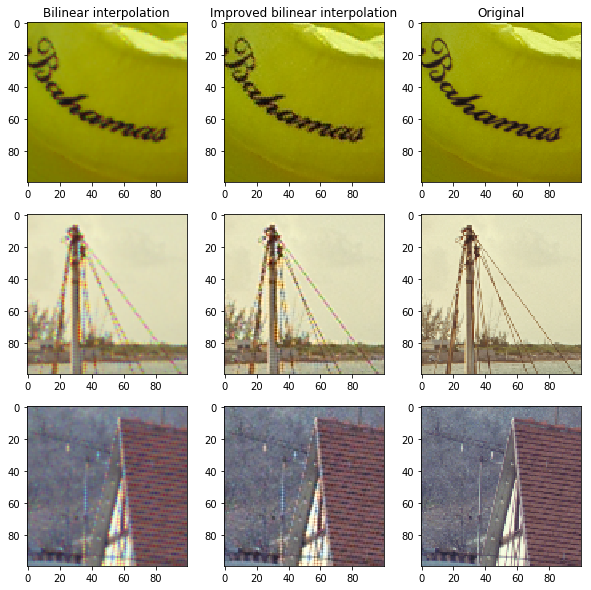

In [31]:
mean_score = np.zeros(4)

file_names = os.listdir(GT_DIR)
for file_name in file_names:
    gt_image = skimage.io.imread(os.path.join(GT_DIR, file_name))
    pred_image = skimage.io.imread(os.path.join(OUTPUT_DIR, file_name))
    mean_score[0] += mse_score(pred_image, gt_image)
    mean_score[1] += psnr_score(pred_image, gt_image)
    pred_image = skimage.io.imread(os.path.join(OUTPUT_DIR2, file_name))
    mean_score[2] += mse_score(pred_image, gt_image)
    mean_score[3] += psnr_score(pred_image, gt_image)
    
mean_score = mean_score / len(file_names)

print("Mean mse score: bilinear = ", mean_score[0], ", improved = ", mean_score[2])
print("Mean psnr score: bilinear = ", mean_score[1], ", improved = ", mean_score[3])

compare_result = [
    [2, 150, 150],
    [5, 50, 300],
    [7, 50, 150]
]

figure = plt.figure(figsize=(10, 10))

for i in range(len(compare_result)):
    cord = compare_result[i]
    gt_image = skimage.io.imread(os.path.join(GT_DIR, file_names[cord[0]]))
    bilinear_image = skimage.io.imread(os.path.join(OUTPUT_DIR, file_names[cord[0]]))
    improved_image = skimage.io.imread(os.path.join(OUTPUT_DIR2, file_names[cord[0]]))
    crop_ind = np.s_[cord[1]: cord[1] + 100, cord[2]: cord[2] + 100,:]
    plt.subplot(3, 3, int(i * 3) + 1)
    plt.imshow(bilinear_image[crop_ind])
    if i == 0:
        plt.title('Bilinear interpolation')
    plt.subplot(3, 3, int(i * 3) + 2)
    plt.imshow(improved_image[crop_ind])
    if i == 0:
        plt.title('Improved bilinear interpolation')
    plt.subplot(3, 3, int(i * 3) + 3)
    plt.imshow(gt_image[crop_ind])
    if i == 0:
        plt.title('Original')

plt.show()

**Выводы: ** Простая билинейная интерполяция даёт более сглаженный результат с ошибками цвета на границах предметов. Улучшение этого метода делает границы объектов более резкими, однако ошибки в цвете всё равно встречаются.